# Obter dados da NBA - Médias das Últimas 3 Temporadas

Coleta dados das últimas 3 temporadas da NBA e calcula médias apenas para jogadores com mais de 50 jogos por temporada.

In [17]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import leaguedashplayerstats, commonplayerinfo
from nba_api.stats.library.parameters import SeasonTypeAllStar
import time
from nba_api.stats.endpoints import playerestimatedmetrics
from nba_api.stats.endpoints import playerdashboardbyyearoveryear
from nba_api.stats.static import players

In [19]:
def normalize_player_name(name):
    """
    Padroniza o nome do jogador removendo Jr., III, etc. e caracteres especiais
    """
    # Remover sufixos comuns e caracteres especiais
    suffixes = [' Jr.', ' III', ' II', ' IV', ' Sr.']
    name = name.strip()
    for suffix in suffixes:
        name = name.replace(suffix, '')
    
    # Remover acentos e caracteres especiais
    import unicodedata
    name = ''.join(c for c in unicodedata.normalize('NFD', name)
                  if unicodedata.category(c) != 'Mn')
    
    return name.upper()  # Converter para maiúsculas para garantir consistência

def process_salary_data(salary_df):
    """
    Processa os dados de salário dos jogadores, substituindo zeros pela média 
    e calculando a média final por jogador
    """
    # Normalizar nomes dos jogadores
    salary_df['Player Name'] = salary_df['Player Name'].apply(normalize_player_name)
    
    # Renomear colunas para facilitar o processamento
    salary_cols = ['2022/2023', '2023/2024', '2024/2025']
    
    # Converter valores de salário para numérico, removendo '$' e ',' 
    for col in salary_cols:
        salary_df[col] = salary_df[col].replace(r'\$', '', regex=True).replace(',', '', regex=True).astype(float)
    print(salary_df)
    # Para cada jogador, substituir valores zero pela média dos valores não nulos
    for idx in salary_df.index:
        player_salaries = salary_df.loc[idx, salary_cols]
        non_zero_salaries = player_salaries[player_salaries > 0]
        
        if len(non_zero_salaries) > 0:
            mean_salary = non_zero_salaries.mean()
            # Substituir zeros pela média usando uma abordagem diferente
            for col in salary_cols:
                if salary_df.loc[idx, col] == 0:
                    salary_df.loc[idx, col] = mean_salary
    
    # Calcular a média das três temporadas
    salary_df['SALARY'] = salary_df[salary_cols].mean(axis=1)
    
    # Manter apenas as colunas necessárias
    return salary_df[['Player Name', 'SALARY']]

def get_season_stats(season):
    """Obtém estatísticas de uma temporada específica combinando diferentes tipos de métricas"""
    print(f"Coletando dados da temporada {season}...")
    
    # Lista de measure_types para coletar
    measure_types = ['Base', 'Advanced', 'Misc', 'Defense']
    dfs = []
    
    # Coletar cada tipo de métrica
    for measure_type in measure_types:
        stats = leaguedashplayerstats.LeagueDashPlayerStats(
            season=season,
            season_type_all_star=SeasonTypeAllStar.regular,
            per_mode_detailed='PerGame',
            measure_type_detailed_defense=measure_type
        ).get_data_frames()[0]
        
        # Se não for o primeiro DataFrame, remover colunas que já existem
        if dfs:
            # Colunas comuns que sempre devem ser mantidas
            keep_cols = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 
                        'GP', 'MIN']
            
            # Identificar colunas únicas deste measure_type
            existing_cols = set().union(*[set(df.columns) for df in dfs])
            unique_cols = [col for col in stats.columns if col not in existing_cols or col in keep_cols]
            
            stats = stats[unique_cols]
        
        dfs.append(stats)
        time.sleep(1)  # Respeitar rate limit da API
    
    # Combinar todos os DataFrames
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = pd.merge(
            combined_df,
            df,
            on=['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION'],
            suffixes=('', '_DROP'),
            how='outer'
        )
        
        # Remover colunas duplicadas que receberam sufixo _DROP
        drop_cols = [col for col in combined_df.columns if col.endswith('_DROP')]
        combined_df.drop(columns=drop_cols, inplace=True)
    
    # Adicionar métricas estimadas
    metrics = playerestimatedmetrics.PlayerEstimatedMetrics(
        season=season
    ).get_data_frames()[0]
    time.sleep(1)
    
    # Combinar com métricas estimadas
    final_df = pd.merge(
        combined_df,
        metrics,
        on='PLAYER_ID',
        suffixes=('', '_EST')
    )
    
    # Filtrar jogadores com mais de 50 jogos
    final_df = final_df[final_df['GP'] >= 50].copy()
    
    # Normalizar nomes dos jogadores no DataFrame final
    final_df['PLAYER_NAME_NORMALIZED'] = final_df['PLAYER_NAME'].apply(normalize_player_name)
    
    # Ler e processar dados de salário
    salary_df = pd.read_csv('nba_player_salary.csv')
    processed_salary = process_salary_data(salary_df)
    
    
    # Adicionar dados de salário ao DataFrame final usando o nome normalizado
    final_df = pd.merge(
        final_df,
        processed_salary,
        left_on='PLAYER_NAME_NORMALIZED',
        right_on='Player Name',
        how='left'
    )
    
    # Remover colunas auxiliares
    final_df.drop(['PLAYER_NAME_NORMALIZED', 'Player Name'], axis=1, inplace=True)
    
    # Se houver jogadores sem correspondência de salário, imprimir aviso
    missing_salary = final_df[final_df['SALARY'].isna()]['PLAYER_NAME'].unique()
    if len(missing_salary) > 0:
        print(f"\nAtenção: {len(missing_salary)} jogadores não têm dados de salário:")
        print(missing_salary)
    
    return final_df

In [21]:
def get_player_info_batch(player_ids):
    """Obtém informações de vários jogadores"""
    player_info_list = []
    
    for player_id in player_ids:
        try:
            info = commonplayerinfo.CommonPlayerInfo(player_id=player_id).get_data_frames()[0]
            player_info_list.append(info)
            time.sleep(1)
        except:
            print(f"Erro ao coletar informações para player_id {player_id}")
            continue
    
    return pd.concat(player_info_list) if player_info_list else pd.DataFrame()

In [23]:
def collect_three_season_data():
    """Coleta e combina dados das últimas 3 temporadas"""
    seasons = ['2021-22', '2022-23', '2023-24']
    all_seasons_data = []
    
    # Coletar dados de cada temporada
    for season in seasons:
        season_data = get_season_stats(season)
        season_data['SEASON'] = season
        all_seasons_data.append(season_data)
    
    # Combinar dados de todas as temporadas
    df = pd.concat(all_seasons_data)
    
    # Identificar jogadores que aparecem em todas as temporadas com >= 50 jogos
    player_seasons = df.groupby('PLAYER_ID')['SEASON'].nunique()
    valid_players = player_seasons[player_seasons == 3].index
    
    # Filtrar apenas jogadores válidos
    df = df[df['PLAYER_ID'].isin(valid_players)]
    
    # Coletar informações dos jogadores válidos
    print("Coletando informações dos jogadores...")
    player_info = get_player_info_batch(valid_players)
    player_info=player_info.rename(columns={'PERSON_ID': 'PLAYER_ID'})
    
    # Calcular médias das 3 temporadas
    avg_stats = df.groupby('PLAYER_ID').agg({
        'PLAYER_NAME': 'first',
        'GP': 'mean',
        'MIN': 'mean',
        'OFF_RATING': 'mean',
        'DEF_RATING': 'mean',
        'TS_PCT': 'mean',
        'AST_PCT': 'mean',
        'USG_PCT': 'mean',
        'FG3_PCT': 'mean',
        'E_DEF_RATING': 'mean',
        'PCT_STL': 'mean',
        'PCT_BLK': 'mean',
        'SALARY': 'last'  # Usar o salário mais recente
    }).reset_index()
    
    # Adicionar informações do jogador
    avg_stats = pd.merge(
        avg_stats,
        player_info[['PLAYER_ID', 'POSITION']],
        on='PLAYER_ID'
    )
    
    # Formatar dados no formato necessário para o otimizador
    final_data = {
        'PLAYER_ID': avg_stats['PLAYER_ID'],
        'PLAYER_NAME': avg_stats['PLAYER_NAME'],
        'Position': avg_stats['POSITION'],
        'Salary': avg_stats['SALARY'],
        'OBPM': avg_stats['OFF_RATING'] - 100,
        'TS%': avg_stats['TS_PCT'],
        'AST%': avg_stats['AST_PCT'],
        'USG%': avg_stats['USG_PCT'],
        '3P%': avg_stats['FG3_PCT'],
        'DBPM': avg_stats['DEF_RATING'] - 100,
        'DRAPTOR': avg_stats['E_DEF_RATING'],
        'STL%': avg_stats['PCT_STL'],
        'BLK%': avg_stats['PCT_BLK'],
        'MinutesPlayed': avg_stats['MIN'] * avg_stats['GP']
    }
    
    final_df = pd.DataFrame(final_data)
    
    # Normalizar valores percentuais para decimal
    pct_columns = ['TS%', '3P%', 'AST%', 'USG%', 'STL%', 'BLK%']
    for col in pct_columns:
        final_df[col] = final_df[col] / 100
    
    return final_df

In [25]:
# Coletar dados
print("Iniciando coleta de dados...")
df = collect_three_season_data()

# Salvar dados
df

Iniciando coleta de dados...
Coletando dados da temporada 2021-22...
     Player Id        Player Name   2022/2023   2023/2024   2024/2025  \
0            1      STEPHEN CURRY  48070014.0  51915615.0  55761217.0   
1            2          JOHN WALL  47345760.0         0.0         0.0   
2            3  RUSSELL WESTBROOK  47080179.0         0.0         0.0   
3            4       LEBRON JAMES  44474988.0  46698737.0  50434636.0   
4            5       KEVIN DURANT  44119845.0  47649433.0  51179020.0   
..         ...                ...         ...         ...         ...   
569        570          GABE YORK     32171.0         0.0         0.0   
570        571         IBOU BADJI     18226.0   1761752.0         0.0   
571        572   TRISTAN THOMPSON     16700.0         0.0         0.0   
572        573       RAIQUAN GRAY      5849.0    547349.0         0.0   
573        573      JACOB GILYARD      5849.0    547349.0         0.0   

      2024/2025.1  
0    $59,606,817   
1             

,PLAYER_ID,PLAYER_NAME,Position,Salary,OBPM,TS%,AST%,USG%,3P%,DBPM,DRAPTOR,STL%,BLK%,MinutesPlayed
0,2544,LeBron James,Forward,4.720279e+07,14.633333,0.006107,0.003210,0.003080,0.003633,12.700000,111.733333,0.002117,0.001923,2184.000000
1,101108,Chris Paul,Guard,3.000000e+07,14.733333,0.005600,0.003883,0.001820,0.003543,9.666667,108.100000,0.003110,0.000870,1846.288889
2,200768,Kyle Lowry,Guard,2.900794e+07,12.100000,0.005863,0.002553,0.001560,0.003713,9.833333,108.400000,0.002123,0.001567,1845.266667
3,201143,Al Horford,Center-Forward,1.533333e+07,17.533333,0.006183,0.001370,0.001283,0.004003,8.000000,107.066667,0.001523,0.003123,1891.200000
4,201144,Mike Conley,Guard,2.352000e+07,14.500000,0.005940,0.002887,0.001733,0.004117,9.666667,109.233333,0.002810,0.000833,2097.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,1630578,Alperen Sengun,Center,4.112098e+06,10.933333,0.005787,0.002133,0.002317,0.002927,16.700000,115.533333,0.002397,0.003663,1915.666667
156,1630581,Josh Giddey,Guard,7.075602e+06,10.833333,0.005193,0.002900,0.002267,0.003083,11.633333,111.033333,0.001627,0.001383,2046.333333
157,1630596,Evan Mobley,Center,9.529672e+06,11.733333,0.005883,0.001313,0.002000,0.002797,8.633333,107.733333,0.001673,0.004563,2173.600000
158,1630598,Aaron Wiggins,Guard,1.796071e+06,10.933333,0.006090,0.000877,0.001517,0.003963,11.266667,110.733333,0.001917,0.001180,1284.800000


In [26]:
# Análise dos dados
print("\nResumo dos dados coletados:")
print(f"Total de jogadores: {len(df)}")
print("\nDistribuição por posição:")
print(df['Position'].value_counts())

print("\nEstatísticas básicas:")
print(df.describe())

# Mostrar alguns jogadores de exemplo
print("\nExemplo de jogadores:")
print(df[['PLAYER_NAME', 'Position', 'OBPM', 'DBPM', 'TS%']].head())


Resumo dos dados coletados:
Total de jogadores: 160

Distribuição por posição:
Position
Guard             64
Forward           41
Center            15
Guard-Forward     14
Forward-Center    12
Forward-Guard      9
Center-Forward     5
Name: count, dtype: int64

Estatísticas básicas:
          PLAYER_ID        Salary        OBPM         TS%        AST%  \
count  1.600000e+02  1.550000e+02  160.000000  160.000000  160.000000   
mean   1.270600e+06  1.470805e+07   12.960000    0.005841    0.001578   
std    6.230487e+05  1.243680e+07    2.815421    0.000384    0.000883   
min    2.544000e+03  1.563518e+06    5.400000    0.005047    0.000317   
25%    1.270609e+06  4.499258e+06   10.825000    0.005574    0.000866   
50%    1.628963e+06  1.064000e+07   12.900000    0.005842    0.001323   
75%    1.629681e+06  2.051612e+07   14.708333    0.006027    0.002172   
max    1.630631e+06  5.191562e+07   21.300000    0.007263    0.004313   

             USG%         3P%        DBPM     DRAPTOR    

# Criando Algoritmo genético

In [43]:
from enum import Enum
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass


class SelectionMethod(Enum):
    TOURNAMENT = "tournament"
    ROULETTE = "roulette"
    RANKING = "ranking"


@dataclass
class OptimizationStats:
    generation: int
    best_fitness: float
    avg_fitness: float
    population_diversity: float
    best_lineup: List[int]

class NBALineupOptimizer:
    def __init__(self, 
                 players_df, 
                 population_size=100, 
                 max_generations=50,
                 convergence_generations=10,
                 target_fitness=None,
                 min_diversity=0.1,
                 selection_method=SelectionMethod.TOURNAMENT):
        self.players_df = players_df
        self.population_size = population_size
        self.max_generations = max_generations
        self.convergence_generations = convergence_generations
        self.target_fitness = target_fitness
        self.min_diversity = min_diversity
        self.salary_cap = 176000000 * 0.8 # 80% do salary cap, pois estamos simulando apenas os titulares
        self.positions = ['G', 'G', 'F', 'F', 'C']
        self.stats_history: List[OptimizationStats] = []
        self.selection_method = selection_method
        
        self.position_mapping = {
            'Guard': ['G'],
            'Forward': ['F'],
            'Center': ['C'],
            'Guard-Forward': ['G', 'F'],
            'Forward-Center': ['F', 'C'],
            'Forward-Guard ': ['F', 'G'],
            'Center-Forward': ['C', 'F']
        }

    def select_parents_tournament(self, population: List[List[int]], num_parents: int) -> List[List[int]]:
        """Seleciona pais usando torneio"""
        tournament_size = 3
        selected_parents = []
        
        for _ in range(num_parents):
            tournament = random.sample(population, tournament_size)
            winner = max(tournament, key=self.calculate_fitness)
            selected_parents.append(winner)
            
        return selected_parents

    def select_parents_roulette(self, population: List[List[int]], num_parents: int) -> List[List[int]]:
        """Seleciona pais usando método da roleta"""
        fitness_scores = [max(0.1, self.calculate_fitness(lineup)) for lineup in population]
        total_fitness = sum(fitness_scores)
        
        # Normalizar probabilidades
        probabilities = [score/total_fitness for score in fitness_scores]
        
        # Selecionar pais
        selected_parents = []
        for _ in range(num_parents):
            selected_idx = np.random.choice(len(population), p=probabilities)
            selected_parents.append(population[selected_idx])
            
        return selected_parents

    def select_parents_ranking(self, population: List[List[int]], num_parents: int) -> List[List[int]]:
        """Seleciona pais usando método de ranking"""
        # Calcular fitness e ordenar população
        population_with_fitness = [(lineup, self.calculate_fitness(lineup)) for lineup in population]
        sorted_population = sorted(population_with_fitness, key=lambda x: x[1], reverse=True)
        
        # Atribuir ranks (1 = melhor)
        ranks = list(range(1, len(population) + 1))
        
        # Calcular probabilidades baseadas no rank
        total_rank_sum = sum(ranks)
        probabilities = [(len(population) - rank + 1)/total_rank_sum for rank in ranks]
        
        # Selecionar pais
        selected_parents = []
        for _ in range(num_parents):
            selected_idx = np.random.choice(len(population), p=probabilities)
            selected_parents.append(sorted_population[selected_idx][0])
            
        return selected_parents

    def select_parents(self, population: List[List[int]], num_parents: int) -> List[List[int]]:
        """Interface para diferentes métodos de seleção"""
        if self.selection_method == SelectionMethod.TOURNAMENT:
            return self.select_parents_tournament(population, num_parents)
        elif self.selection_method == SelectionMethod.ROULETTE:
            return self.select_parents_roulette(population, num_parents)
        elif self.selection_method == SelectionMethod.RANKING:
            return self.select_parents_ranking(population, num_parents)
        else:
            raise ValueError(f"Método de seleção inválido: {self.selection_method}")

    def plot_optimization_progress(self):
        """Plota gráficos mostrando o progresso da otimização"""
        generations = [stats.generation for stats in self.stats_history]
        best_fitness = [stats.best_fitness for stats in self.stats_history]
        avg_fitness = [stats.avg_fitness for stats in self.stats_history]
        diversity = [stats.population_diversity for stats in self.stats_history]
        
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Evolução do Fitness
        plt.subplot(2, 1, 1)
        plt.plot(generations, best_fitness, 'b-', label='Melhor Fitness')
        plt.plot(generations, avg_fitness, 'r--', label='Fitness Médio')
        plt.xlabel('Geração')
        plt.ylabel('Fitness')
        plt.title(f'Evolução do Fitness - Método: {self.selection_method.value}')
        plt.legend()
        plt.grid(True)
        
        # Plot 2: Diversidade da População
        plt.subplot(2, 1, 2)
        plt.plot(generations, diversity, 'g-', label='Diversidade')
        plt.xlabel('Geração')
        plt.ylabel('Diversidade')
        plt.title('Diversidade da População')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

    def compare_selection_methods(self, num_runs=3):
        """Compara diferentes métodos de seleção"""
        results = {method: [] for method in SelectionMethod}
        
        for method in SelectionMethod:
            print(f"\nTestando método de seleção: {method.value}")
            self.selection_method = method
            
            for run in range(num_runs):
                print(f"\nExecução {run + 1}/{num_runs}")
                self.stats_history = []  # Limpar histórico anterior
                best_lineup, best_fitness = self.optimize()
                self.display_lineup(best_lineup)
                results[method].append({
                    'fitness': best_fitness,
                    'generations': len(self.stats_history),
                    'final_diversity': self.stats_history[-1].population_diversity
                })
        
        # Plotar comparação
        self.plot_comparison_results(results)
        return results

    def plot_comparison_results(self, results: Dict):
        """Plota comparação entre diferentes métodos de seleção"""
        plt.figure(figsize=(15, 5))
        
        # Preparar dados
        methods = list(results.keys())
        avg_fitness = [np.mean([run['fitness'] for run in results[method]]) for method in methods]
        std_fitness = [np.std([run['fitness'] for run in results[method]]) for method in methods]
        
        # Plot de barras com desvio padrão
        x_pos = np.arange(len(methods))
        plt.bar(x_pos, avg_fitness, yerr=std_fitness, align='center', alpha=0.8,
                ecolor='black', capsize=10)
        
        plt.xlabel('Método de Seleção')
        plt.ylabel('Fitness Médio')
        plt.title('Comparação entre Métodos de Seleção')
        plt.xticks(x_pos, [method.value for method in methods])
        plt.grid(True, axis='y')
        
        plt.tight_layout()
        plt.show()
    
    def calculate_population_diversity(self, population: List[List[int]]) -> float:
        """Calcula a diversidade da população usando distância de Jaccard média"""
        if len(population) < 2:
            return 0.0
            
        distances = []
        for i in range(len(population)):
            for j in range(i + 1, len(population)):
                set1 = set(population[i])
                set2 = set(population[j])
                jaccard = len(set1.intersection(set2)) / len(set1.union(set2))
                distances.append(1 - jaccard)  # Convertemos similaridade em distância
                
        return np.mean(distances)

    def is_valid_lineup(self, lineup: List[int]) -> bool:
        if len(lineup) != 5:
            return False
        
        players = self.players_df[self.players_df['PLAYER_ID'].isin(lineup)]
        if players['Salary'].sum() > self.salary_cap:
            return False
        
        # Verificar contagem de posições
        # Supondo que precisamos 2 G, 2 F e 1 C
        positions_count = {'G': 0, 'F': 0, 'C': 0}
        for pos in players['Position']:
            # Caso a posição do jogador seja combinada (ex: 'G-F'), 
            # você precisará ajustar a lógica para contabilizar corretamente.
            # Aqui simplificamos assumindo que a coluna 'Position' tem apenas 'G', 'F', ou 'C'.
            if 'G' in pos:
                positions_count['G'] += 1
            if 'F' in pos:
                positions_count['F'] += 1
            if 'C' in pos:
                positions_count['C'] += 1
        
        # Exemplo de critério, caso seja fixo:
        if positions_count['G'] < 2 or positions_count['F'] < 2 or positions_count['C'] < 1:
            return False
        
        return True

    def should_stop(self) -> bool:
        """Verifica se algum critério de parada foi atingido"""
        if len(self.stats_history) == 0:
            return False
            
        # Verificar número máximo de gerações
        if len(self.stats_history) >= self.max_generations:
            print("Critério de parada: Número máximo de gerações atingido")
            return True
            
        # Verificar convergência
        if len(self.stats_history) >= self.convergence_generations:
            recent_best = [stats.best_fitness for stats in self.stats_history[-self.convergence_generations:]]
            if max(recent_best) - min(recent_best) < 0.001:
                print("Critério de parada: Convergência detectada")
                return True
                
        # Verificar meta de fitness
        if self.target_fitness and self.stats_history[-1].best_fitness >= self.target_fitness:
            print("Critério de parada: Meta de fitness atingida")
            return True
            
        # Verificar diversidade mínima
        if self.stats_history[-1].population_diversity < self.min_diversity:
            print("Critério de parada: Diversidade mínima atingida")
            return True
            
        return False

    
        
    def create_initial_population(self) -> List[List[int]]:
        """Cria população inicial de lineups válidos"""
        population = []
        
        while len(population) < self.population_size:
            lineup = self.create_valid_lineup()
            if lineup and self.is_valid_lineup(lineup):
                population.append(lineup)
                
        return population
    
    def create_valid_lineup(self) -> List[int]:
        """Cria um lineup válido com verificações adicionais de segurança"""
        max_attempts = 100  # Limite máximo de tentativas
        attempt = 0
        
        while attempt < max_attempts:
            lineup = []
            remaining_positions = self.positions.copy()
            
            # Filtrar jogadores por posição e tentar criar um lineup válido
            while remaining_positions and len(lineup) < 5:
                needed_position = remaining_positions[0]
                
                # Pegar jogadores elegíveis para a posição
                eligible_players = self.get_eligible_players(needed_position, lineup)
                
                if not eligible_players.empty:
                    player = eligible_players.sample(1)
                    player_id = player.iloc[0]['PLAYER_ID']
                    
                    if player_id not in lineup:
                        lineup.append(player_id)
                        remaining_positions.pop(0)
                else:
                    break  # Se não houver jogadores elegíveis, interrompe este tentativa
                    
            # Verificar se criamos um lineup válido
            if len(lineup) == 5 and self.is_valid_lineup(lineup):
                return lineup
                
            attempt += 1
        
        # Se não conseguiu criar um lineup válido após várias tentativas
        # Retorna uma solução de backup usando os primeiros jogadores válidos encontrados
        backup_lineup = []
        for pos in self.positions:
            eligible = self.players_df[self.players_df['Position'].apply(
                lambda x: pos in self.position_mapping.get(x, [])
            )].head(1)
            if not eligible.empty:
                backup_lineup.append(eligible.iloc[0]['PLAYER_ID'])
                
        # Se mesmo assim não conseguir criar um lineup válido, levanta uma exceção
        if len(backup_lineup) != 5:
            raise ValueError("Não foi possível criar um lineup válido após múltiplas tentativas")
            
        return backup_lineup
    
    def get_eligible_players(self, position: str, current_lineup: List[int]) -> pd.DataFrame:
        """Retorna jogadores elegíveis para uma posição específica"""
        # Filtrar jogadores que já estão no lineup
        available_players = self.players_df[~self.players_df['PLAYER_ID'].isin(current_lineup)]
        
        # Filtrar por posição
        eligible_players = available_players[available_players['Position'].apply(
            lambda x: position in self.position_mapping.get(x, [])
        )]
        
        # Verificar salary cap
        if current_lineup:
            current_salary = self.players_df[self.players_df['PLAYER_ID'].isin(current_lineup)]['Salary'].sum()
            eligible_players = eligible_players[
                eligible_players['Salary'] <= (self.salary_cap - current_salary)
            ]
            
        return eligible_players
    
    def calculate_fitness(self, lineup: List[int]) -> float:
        """Calcula o fitness de um lineup baseado nas métricas coletadas"""
        if not self.is_valid_lineup(lineup):
            return 0
            
        players = self.players_df[self.players_df['PLAYER_ID'].isin(lineup)]
        
        # Pesos para diferentes métricas
        weights = {
            'OBPM': 0.31,
            'DBPM': 0.28,
            'TS%': 0.14,
            'AST%': 0.05,
            'USG%': 0.05,
            '3P%': 0.08,
            'STL%': 0.05,
            'BLK%': 0.04
        }
        
        # Calcular score ponderado
        total_score = 0
        for metric, weight in weights.items():
            total_score += players[metric].mean() * weight
            
        return total_score
        
    def crossover(self, parent1: List[int], parent2: List[int]) -> Tuple[List[int], List[int]]:
        """Realiza crossover entre dois lineups com verificações de segurança"""
        # Verificar se os parents são válidos
        if not parent1 or not parent2 or len(parent1) != 5 or len(parent2) != 5:
            return self.create_valid_lineup(), self.create_valid_lineup()
            
        # Escolher ponto de crossover
        crossover_point = random.randint(1, 4)
        
        # Criar filhos
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        
        # Verificar e corrigir lineups inválidos
        if not self.is_valid_lineup(child1):
            child1 = self.create_valid_lineup()
        if not self.is_valid_lineup(child2):
            child2 = self.create_valid_lineup()
            
        # Garantir que não retornamos None ou lineup vazio
        if not child1 or len(child1) != 5:
            child1 = self.create_valid_lineup()
        if not child2 or len(child2) != 5:
            child2 = self.create_valid_lineup()
            
        return child1, child2

    def mutate(self, lineup: List[int], mutation_rate: float = 0.1) -> List[int]:
        """Realiza mutação em um lineup com verificações de segurança"""
        # Verificar se o lineup é válido antes de tentar mutação
        if not lineup or len(lineup) != 5:
            return self.create_valid_lineup()
            
        if random.random() < mutation_rate:
            # Escolher posição aleatória para mutar
            position_idx = random.randint(0, 4)
            needed_position = self.positions[position_idx]
            
            # Criar uma cópia do lineup para evitar modificação direta
            new_lineup = lineup.copy()
            
            # Remover jogador atual com verificação de segurança
            if 0 <= position_idx < len(new_lineup):
                old_player = new_lineup.pop(position_idx)
                
                # Tentar adicionar novo jogador válido
                eligible_players = self.get_eligible_players(needed_position, new_lineup)
                if not eligible_players.empty:
                    new_player = eligible_players.sample(1).iloc[0]['PLAYER_ID']
                    new_lineup.insert(position_idx, new_player)
                else:
                    new_lineup.insert(position_idx, old_player)
                    
                # Verificar se o novo lineup é válido
                if self.is_valid_lineup(new_lineup):
                    return new_lineup
                    
        return lineup
    
    def select_parents(self, population: List[List[int]], num_parents: int) -> List[List[int]]:
        """Seleciona pais usando torneio"""
        tournament_size = 3
        selected_parents = []
        
        for _ in range(num_parents):
            tournament = random.sample(population, tournament_size)
            winner = max(tournament, key=self.calculate_fitness)
            selected_parents.append(winner)
            
        return selected_parents

    def optimize(self) -> Tuple[List[int], float]:
        """Executa o algoritmo genético com tratamento de erros aprimorado"""
        try:
            # Criar população inicial com verificação
            population = []
            max_attempts = 100
            attempt = 0
            
            while len(population) < self.population_size and attempt < max_attempts:
                lineup = self.create_valid_lineup()
                if lineup and self.is_valid_lineup(lineup):
                    population.append(lineup)
                attempt += 1
                
            if not population:
                raise ValueError("Não foi possível criar uma população inicial válida")
                
            best_lineup = None
            best_fitness = float('-inf')
            
            generation = 0
            while True:
                try:
                    # Avaliar população atual
                    fitness_scores = [(lineup, self.calculate_fitness(lineup)) 
                                    for lineup in population if lineup and len(lineup) == 5]
                    
                    if not fitness_scores:
                        raise ValueError("População não contém lineups válidos")
                        
                    current_best = max(fitness_scores, key=lambda x: x[1])
                    avg_fitness = np.mean([score for _, score in fitness_scores])
                    diversity = self.calculate_population_diversity(population)
                    
                    # Atualizar melhor resultado
                    if current_best[1] > best_fitness:
                        best_lineup = current_best[0]
                        best_fitness = current_best[1]
                    
                    # Registrar estatísticas
                    self.stats_history.append(OptimizationStats(
                        generation=generation,
                        best_fitness=best_fitness,
                        avg_fitness=avg_fitness,
                        population_diversity=diversity,
                        best_lineup=best_lineup
                    ))
                    
                    # Verificar critérios de parada
                    if self.should_stop():
                        break
                    
                    # Selecionar pais e criar nova população com verificações
                    parents = self.select_parents(population, self.population_size)
                    new_population = []
                    
                    while len(new_population) < self.population_size:
                        if len(parents) < 2:
                            break
                            
                        parent1, parent2 = random.sample(parents, 2)
                        child1, child2 = self.crossover(parent1, parent2)
                        
                        if child1 and len(child1) == 5:
                            child1 = self.mutate(child1)
                        if child2 and len(child2) == 5:
                            child2 = self.mutate(child2)
                        
                        if child1 and len(child1) == 5:
                            new_population.append(child1)
                        if child2 and len(child2) == 5:
                            new_population.append(child2)
                    
                    # Garantir que temos uma população válida
                    if not new_population:
                        raise ValueError("Não foi possível criar uma nova população válida")
                        
                    population = new_population[:self.population_size]
                    generation += 1
                    
                    # Mostrar progresso
                    if generation % 5 == 0:
                        print(f"Geração {generation}: Melhor Fitness = {best_fitness:.4f}, "
                              f"Fitness Médio = {avg_fitness:.4f}, Diversidade = {diversity:.4f}")
                    
                        
                except Exception as e:
                    print(f"Erro durante a geração {generation}: {str(e)}")
                    if best_lineup:
                        return best_lineup, best_fitness
                    raise
                    
            # Plotar resultados finais
            self.plot_optimization_progress()   
            
            return best_lineup, best_fitness
            
        except Exception as e:
            print(f"Erro durante a otimização: {str(e)}")
            raise

    def display_lineup(self, lineup: List[int]):
        """Exibe informações detalhadas do lineup"""
        players = self.players_df[self.players_df['PLAYER_ID'].isin(lineup)]
        
        print("\nMelhor Lineup Encontrado:")
        print("-" * 80)
        for _, player in players.iterrows():
            print(f"Nome: {player['PLAYER_NAME']}")
            print(f"Posição: {player['Position']}")
            print(f"Salário: ${player['Salary']:,.2f}")
            print(f"OBPM: {player['OBPM']:.2f}")
            print(f"DBPM: {player['DBPM']:.2f}")
            print(f"TS%: {player['TS%']:.3f}")
            print("-" * 80)
        
        print(f"Salário Total: ${players['Salary'].sum():,.2f}")
        print(f"Média OBPM: {players['OBPM'].mean():.2f}")
        print(f"Média DBPM: {players['DBPM'].mean():.2f}")


Testando método de seleção: tournament

Execução 1/3
Geração 5: Melhor Fitness = 9.5118, Fitness Médio = 8.5198, Diversidade = 0.9135
Geração 10: Melhor Fitness = 9.6070, Fitness Médio = 9.1802, Diversidade = 0.6740
Geração 15: Melhor Fitness = 9.6070, Fitness Médio = 9.3349, Diversidade = 0.4225
Critério de parada: Convergência detectada


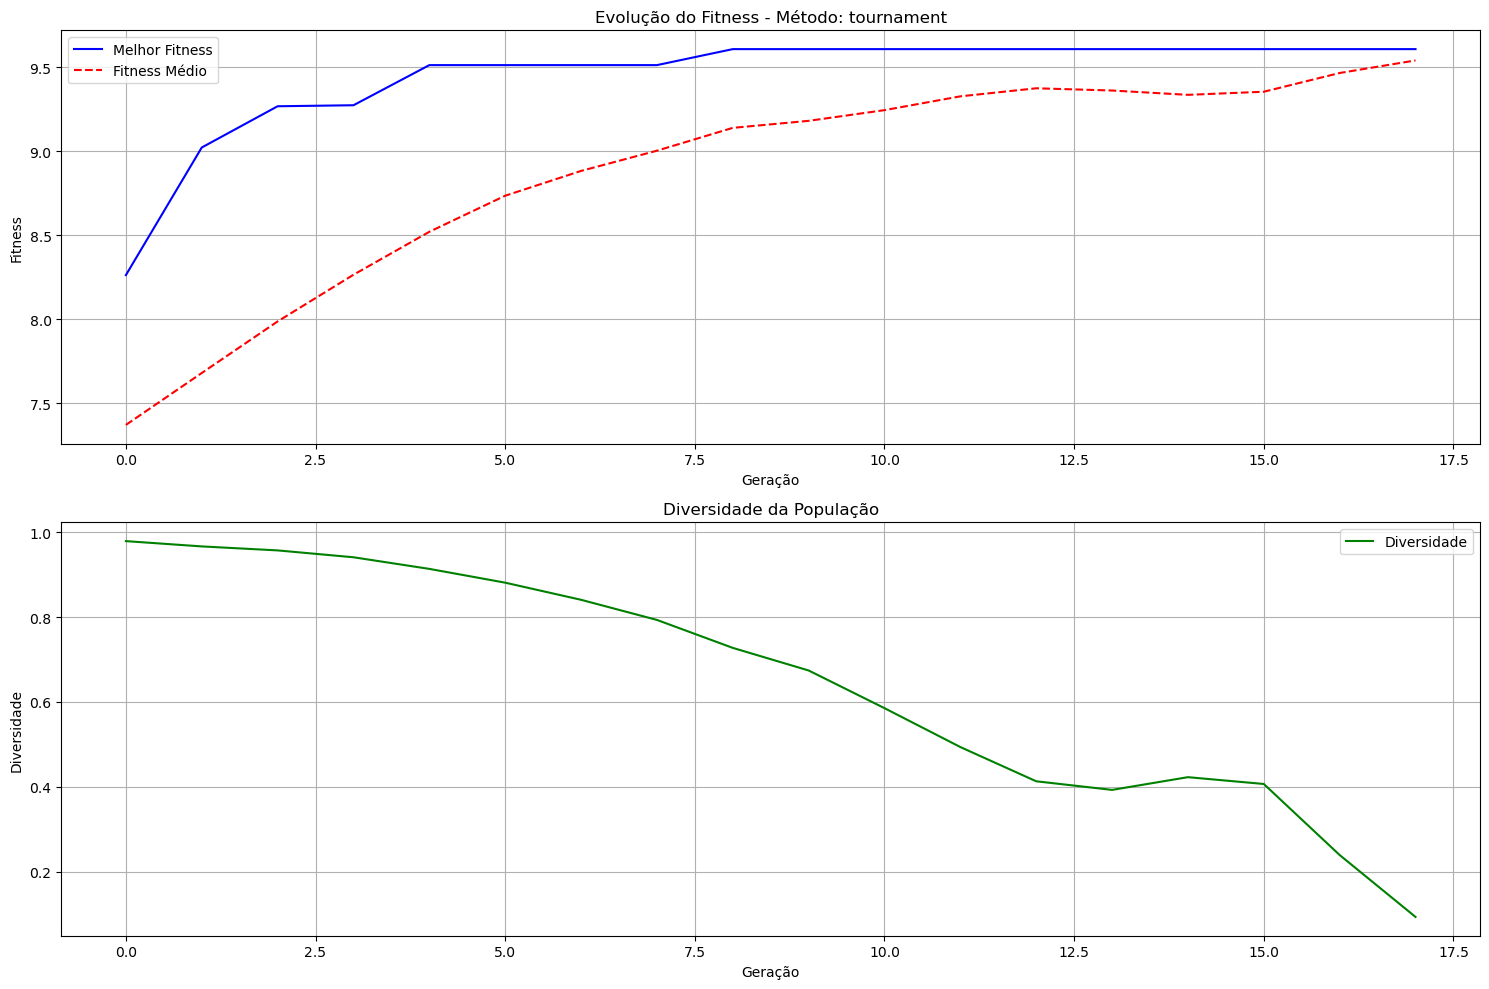


Melhor Lineup Encontrado:
--------------------------------------------------------------------------------
Nome: Aaron Gordon
Posição: Forward
Salário: $21,266,182.00
OBPM: 20.03
DBPM: 11.03
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Nikola Jokić
Posição: Center
Salário: $43,290,601.00
OBPM: 21.30
DBPM: 10.37
TS%: 0.007
--------------------------------------------------------------------------------
Nome: Kevin Huerter
Posição: Guard-Forward
Salário: $15,669,643.00
OBPM: 18.30
DBPM: 14.70
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Trae Young
Posição: Guard
Salário: $40,064,220.00
OBPM: 16.57
DBPM: 16.20
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Tyrese Haliburton
Posição: Guard
Salário: $6,005,320.33
OBPM: 16.43
DBPM: 16.67
TS%: 0.006
--------------------------------------------------------------------------------
Salário 

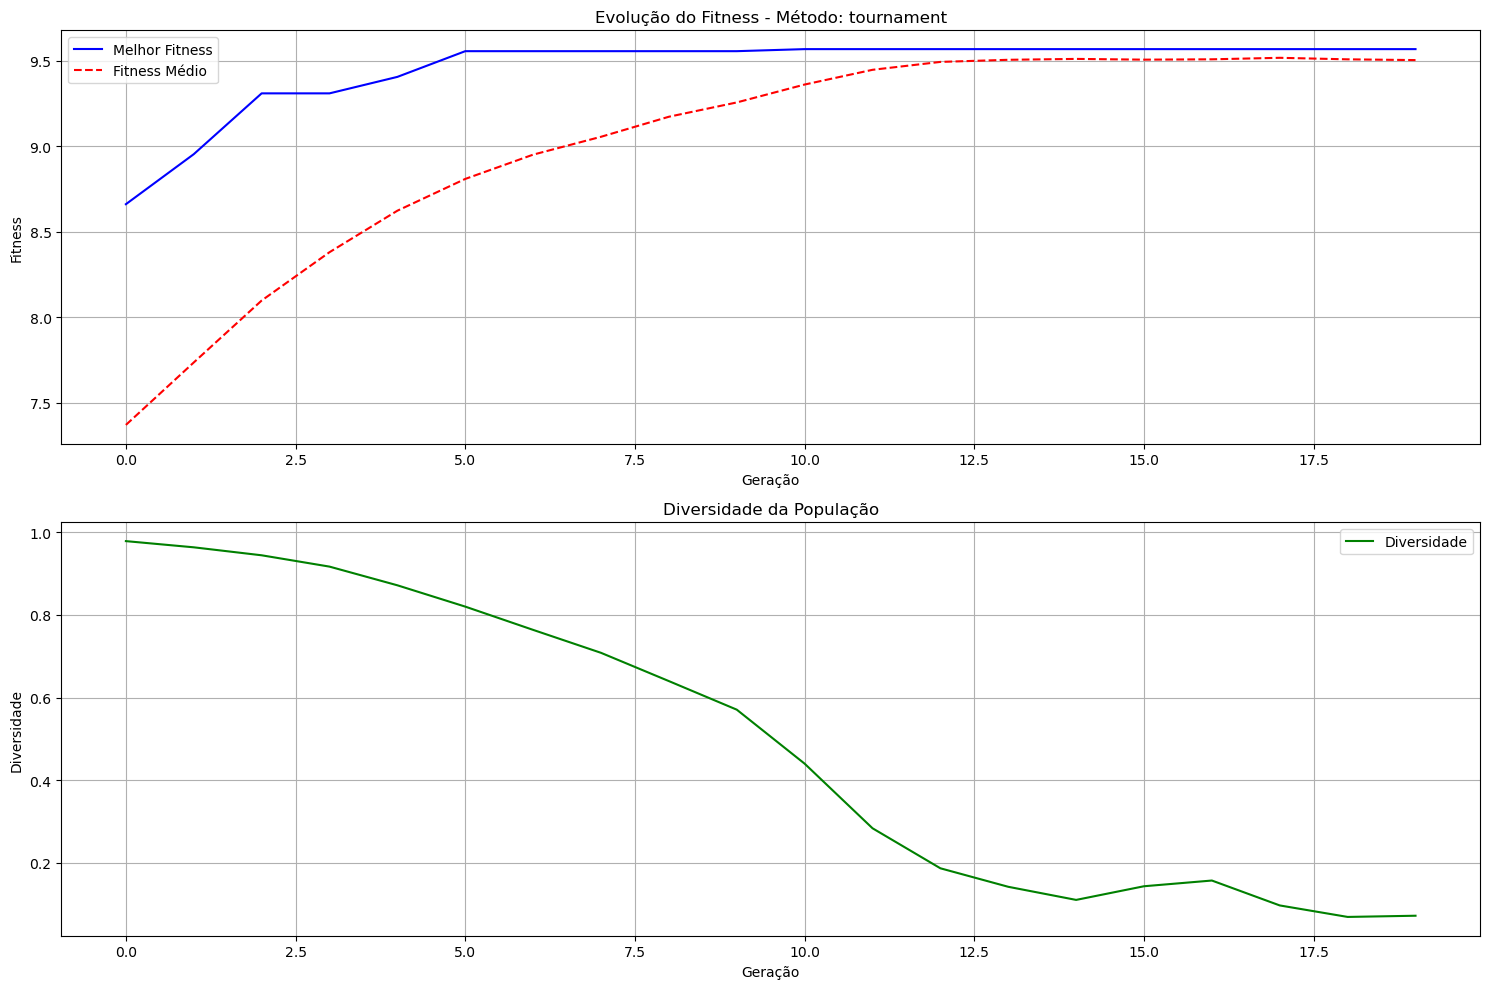


Melhor Lineup Encontrado:
--------------------------------------------------------------------------------
Nome: John Collins
Posição: Forward-Center
Salário: $25,140,000.00
OBPM: 14.23
DBPM: 16.53
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Kevin Huerter
Posição: Guard-Forward
Salário: $15,669,643.00
OBPM: 18.30
DBPM: 14.70
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Trae Young
Posição: Guard
Salário: $40,064,220.00
OBPM: 16.57
DBPM: 16.20
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Tyrese Haliburton
Posição: Guard
Salário: $6,005,320.33
OBPM: 16.43
DBPM: 16.67
TS%: 0.006
--------------------------------------------------------------------------------
Salário Total: $86,879,183.33
Média OBPM: 16.38
Média DBPM: 16.03

Execução 3/3
Geração 5: Melhor Fitness = 9.3170, Fitness Médio = 8.5294, Diversidade = 0.9136
Geração 10: Mel

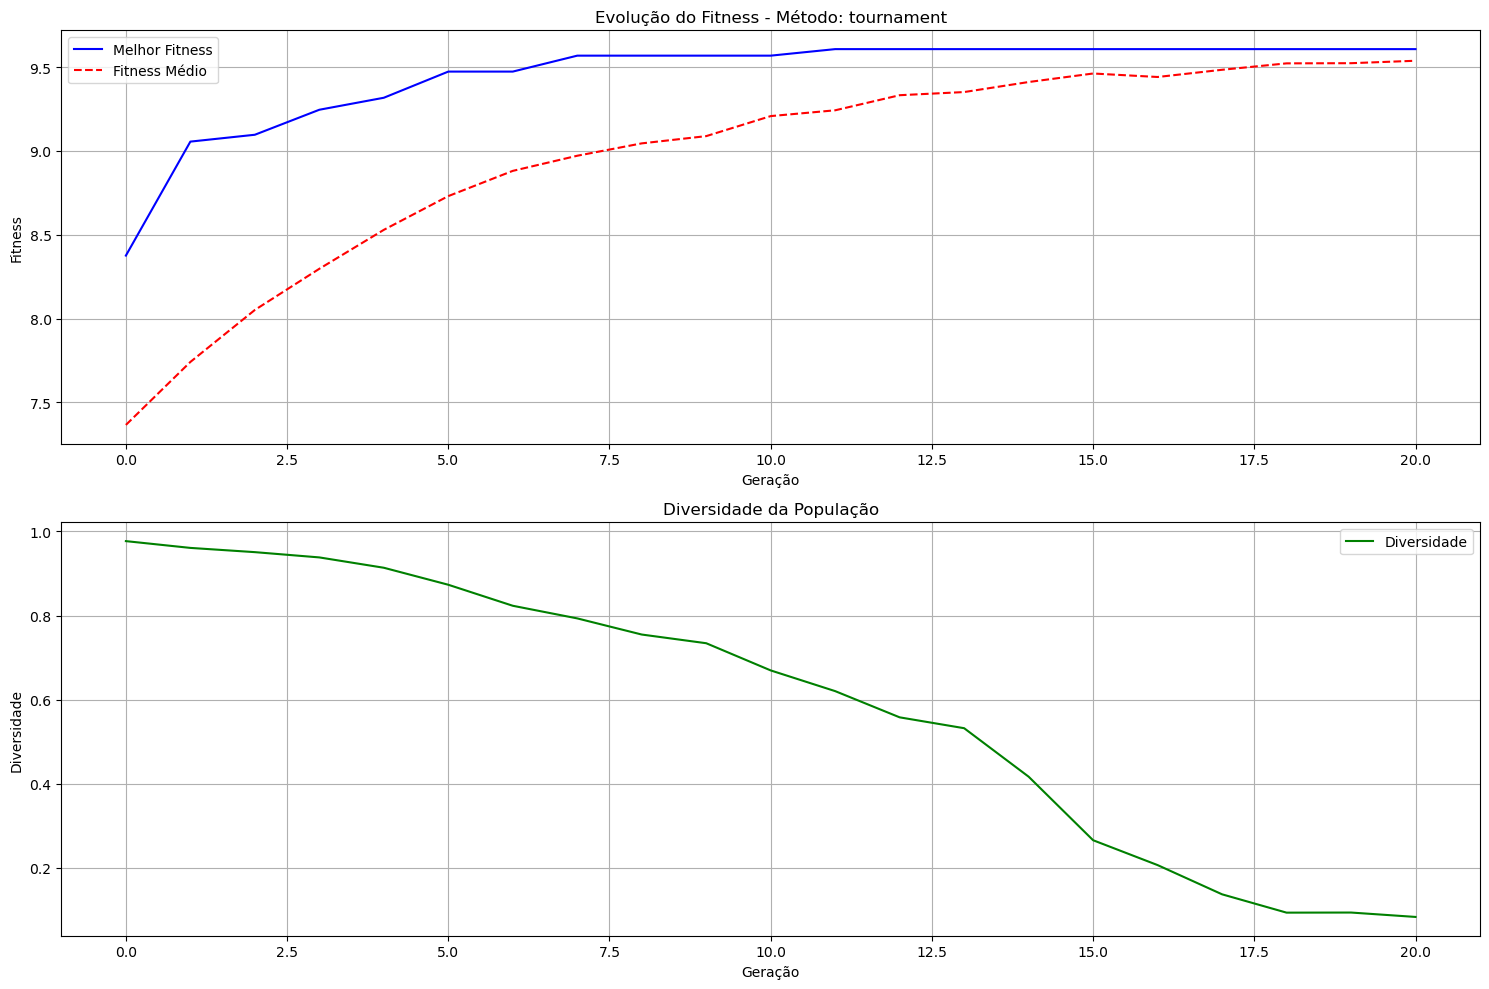


Melhor Lineup Encontrado:
--------------------------------------------------------------------------------
Nome: Aaron Gordon
Posição: Forward
Salário: $21,266,182.00
OBPM: 20.03
DBPM: 11.03
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Nikola Jokić
Posição: Center
Salário: $43,290,601.00
OBPM: 21.30
DBPM: 10.37
TS%: 0.007
--------------------------------------------------------------------------------
Nome: Kevin Huerter
Posição: Guard-Forward
Salário: $15,669,643.00
OBPM: 18.30
DBPM: 14.70
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Trae Young
Posição: Guard
Salário: $40,064,220.00
OBPM: 16.57
DBPM: 16.20
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Tyrese Haliburton
Posição: Guard
Salário: $6,005,320.33
OBPM: 16.43
DBPM: 16.67
TS%: 0.006
--------------------------------------------------------------------------------
Salário 

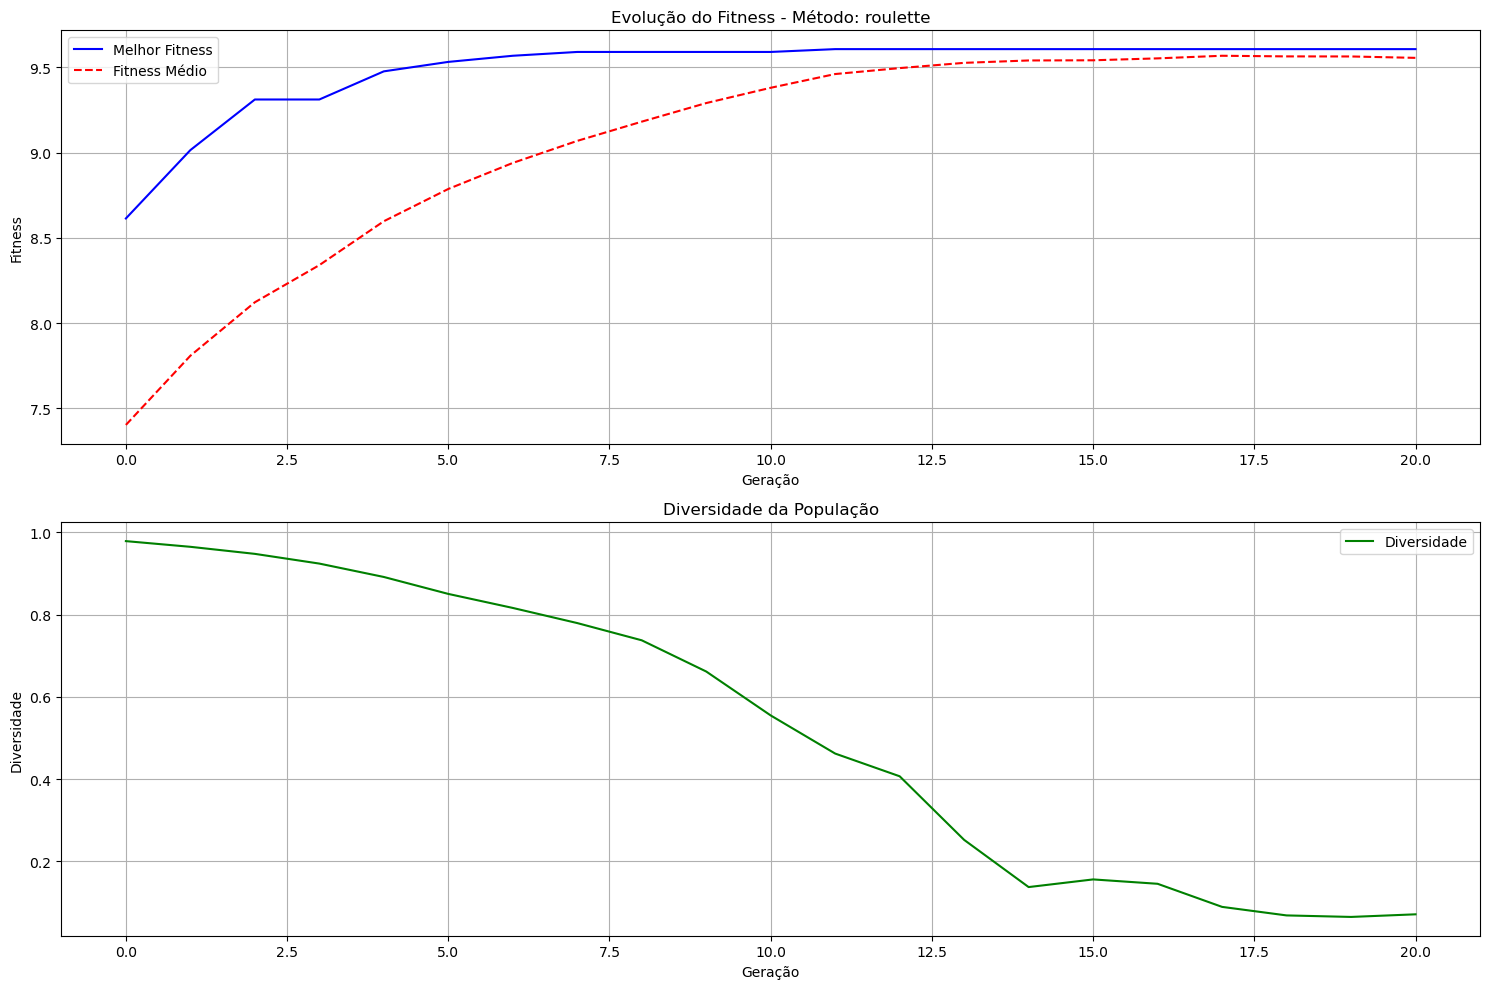


Melhor Lineup Encontrado:
--------------------------------------------------------------------------------
Nome: Aaron Gordon
Posição: Forward
Salário: $21,266,182.00
OBPM: 20.03
DBPM: 11.03
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Nikola Jokić
Posição: Center
Salário: $43,290,601.00
OBPM: 21.30
DBPM: 10.37
TS%: 0.007
--------------------------------------------------------------------------------
Nome: Kevin Huerter
Posição: Guard-Forward
Salário: $15,669,643.00
OBPM: 18.30
DBPM: 14.70
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Trae Young
Posição: Guard
Salário: $40,064,220.00
OBPM: 16.57
DBPM: 16.20
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Tyrese Haliburton
Posição: Guard
Salário: $6,005,320.33
OBPM: 16.43
DBPM: 16.67
TS%: 0.006
--------------------------------------------------------------------------------
Salário 

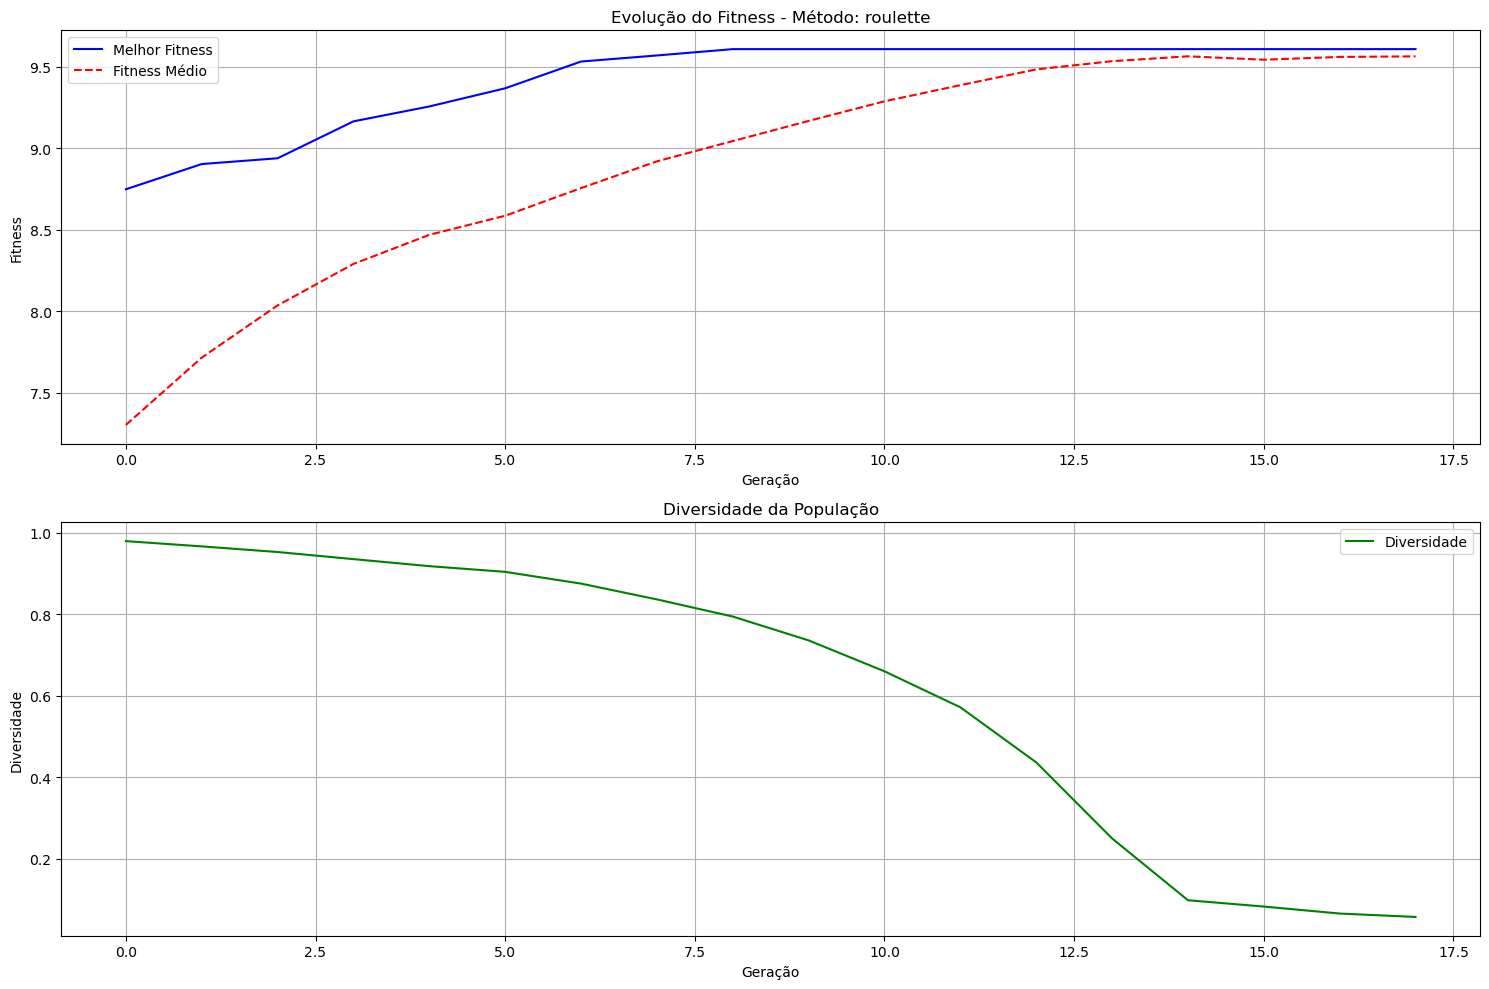


Melhor Lineup Encontrado:
--------------------------------------------------------------------------------
Nome: Aaron Gordon
Posição: Forward
Salário: $21,266,182.00
OBPM: 20.03
DBPM: 11.03
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Nikola Jokić
Posição: Center
Salário: $43,290,601.00
OBPM: 21.30
DBPM: 10.37
TS%: 0.007
--------------------------------------------------------------------------------
Nome: Kevin Huerter
Posição: Guard-Forward
Salário: $15,669,643.00
OBPM: 18.30
DBPM: 14.70
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Trae Young
Posição: Guard
Salário: $40,064,220.00
OBPM: 16.57
DBPM: 16.20
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Tyrese Haliburton
Posição: Guard
Salário: $6,005,320.33
OBPM: 16.43
DBPM: 16.67
TS%: 0.006
--------------------------------------------------------------------------------
Salário 

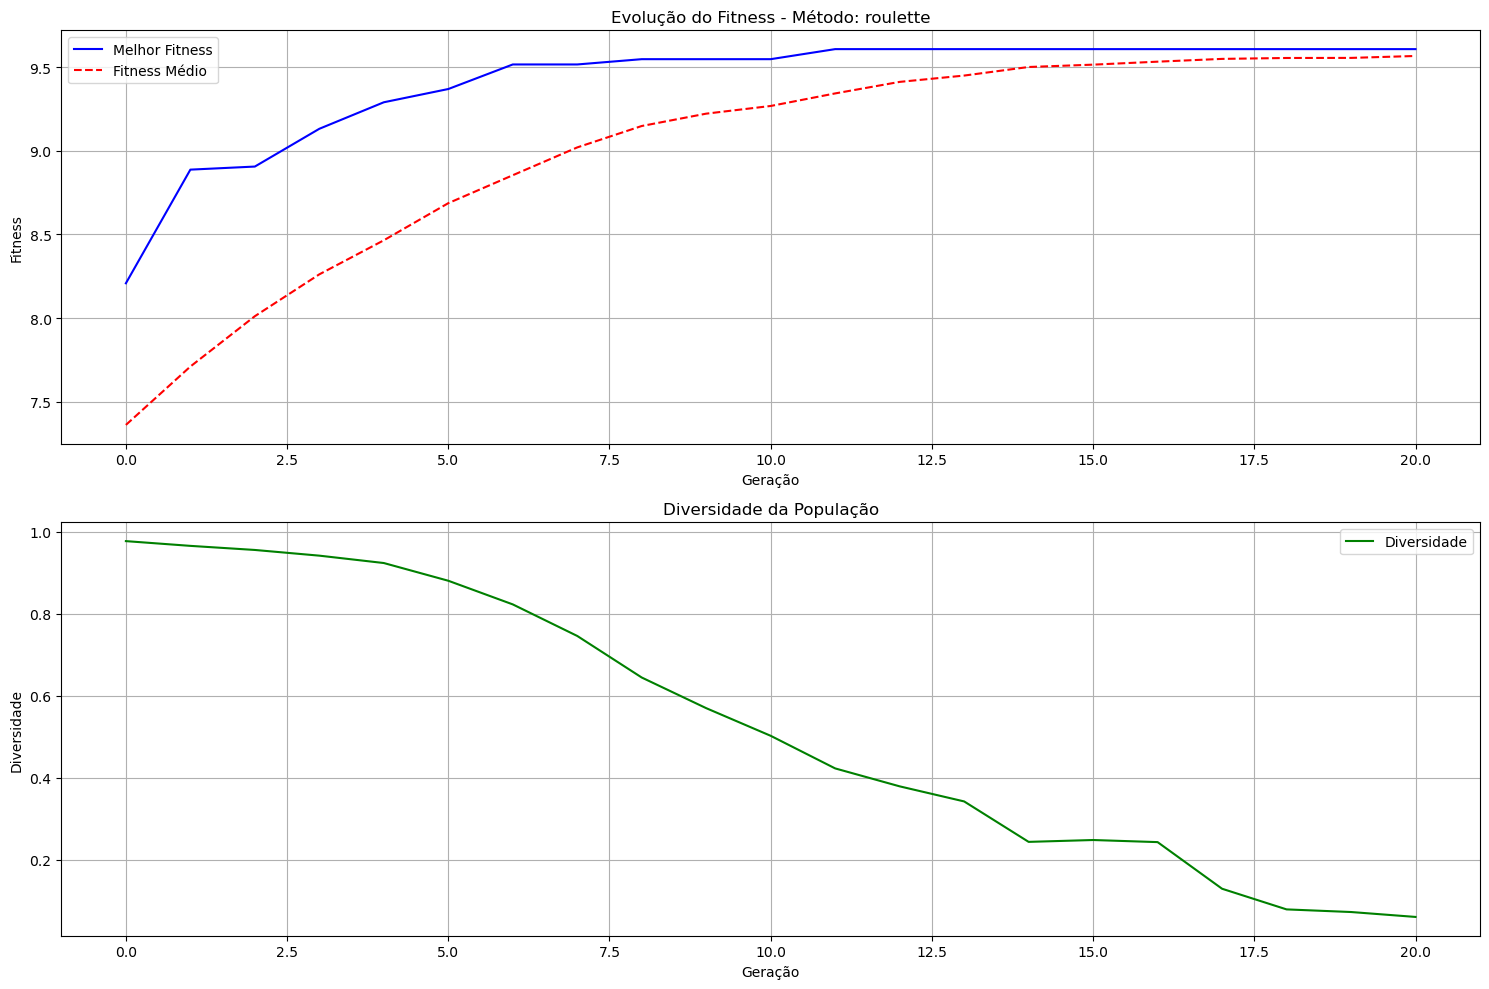


Melhor Lineup Encontrado:
--------------------------------------------------------------------------------
Nome: Aaron Gordon
Posição: Forward
Salário: $21,266,182.00
OBPM: 20.03
DBPM: 11.03
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Nikola Jokić
Posição: Center
Salário: $43,290,601.00
OBPM: 21.30
DBPM: 10.37
TS%: 0.007
--------------------------------------------------------------------------------
Nome: Kevin Huerter
Posição: Guard-Forward
Salário: $15,669,643.00
OBPM: 18.30
DBPM: 14.70
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Trae Young
Posição: Guard
Salário: $40,064,220.00
OBPM: 16.57
DBPM: 16.20
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Tyrese Haliburton
Posição: Guard
Salário: $6,005,320.33
OBPM: 16.43
DBPM: 16.67
TS%: 0.006
--------------------------------------------------------------------------------
Salário 

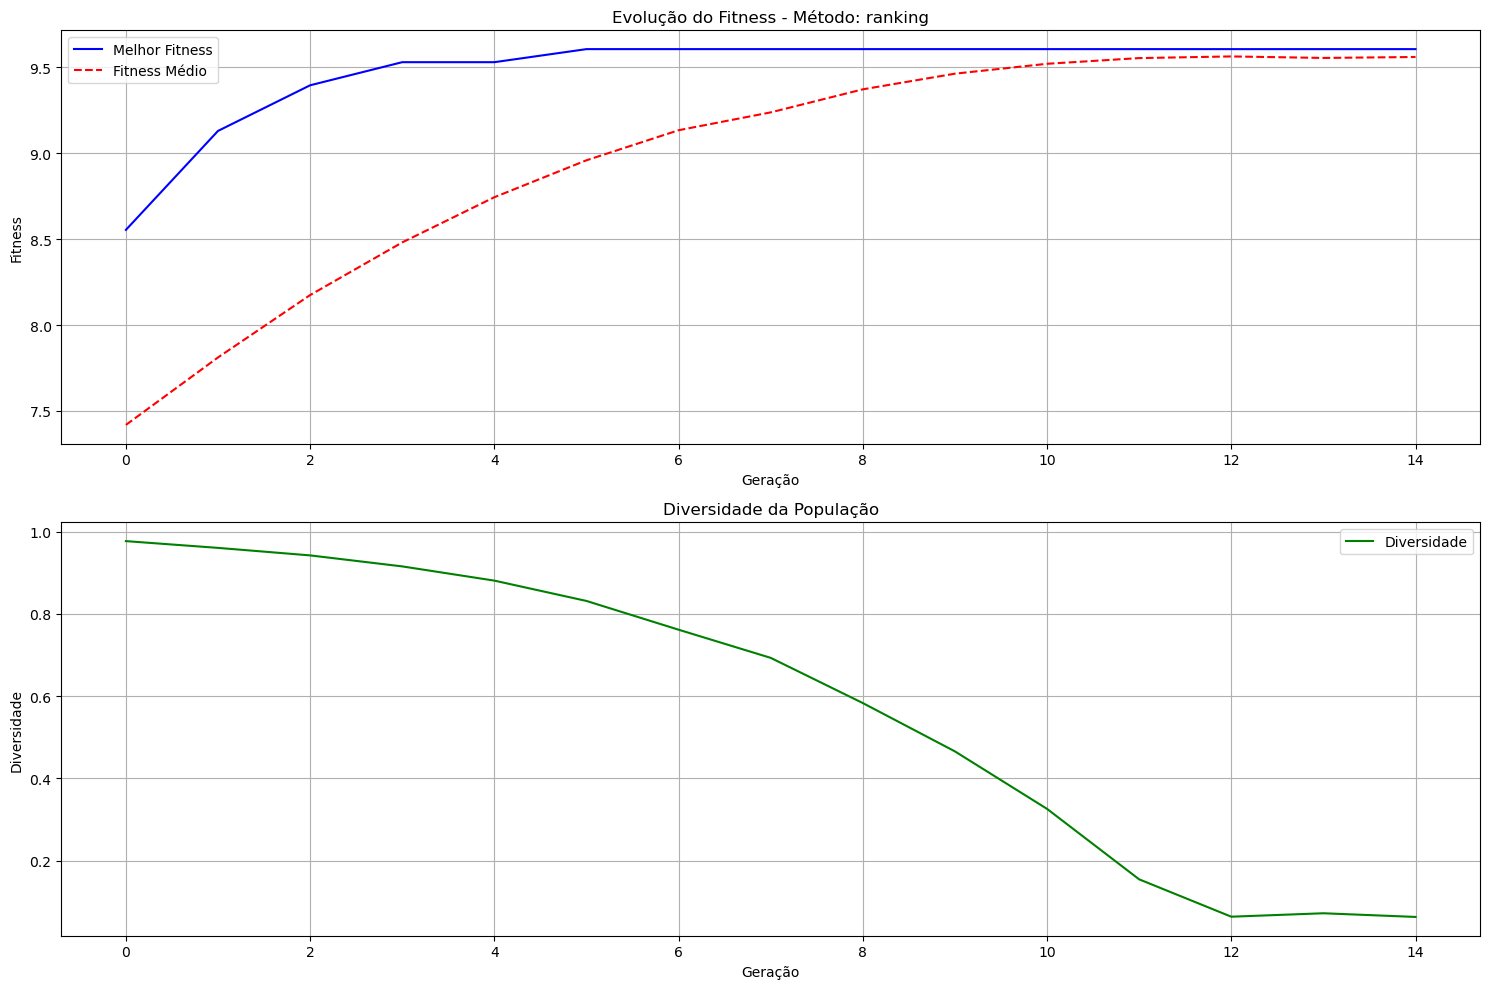


Melhor Lineup Encontrado:
--------------------------------------------------------------------------------
Nome: Aaron Gordon
Posição: Forward
Salário: $21,266,182.00
OBPM: 20.03
DBPM: 11.03
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Nikola Jokić
Posição: Center
Salário: $43,290,601.00
OBPM: 21.30
DBPM: 10.37
TS%: 0.007
--------------------------------------------------------------------------------
Nome: Kevin Huerter
Posição: Guard-Forward
Salário: $15,669,643.00
OBPM: 18.30
DBPM: 14.70
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Trae Young
Posição: Guard
Salário: $40,064,220.00
OBPM: 16.57
DBPM: 16.20
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Tyrese Haliburton
Posição: Guard
Salário: $6,005,320.33
OBPM: 16.43
DBPM: 16.67
TS%: 0.006
--------------------------------------------------------------------------------
Salário 

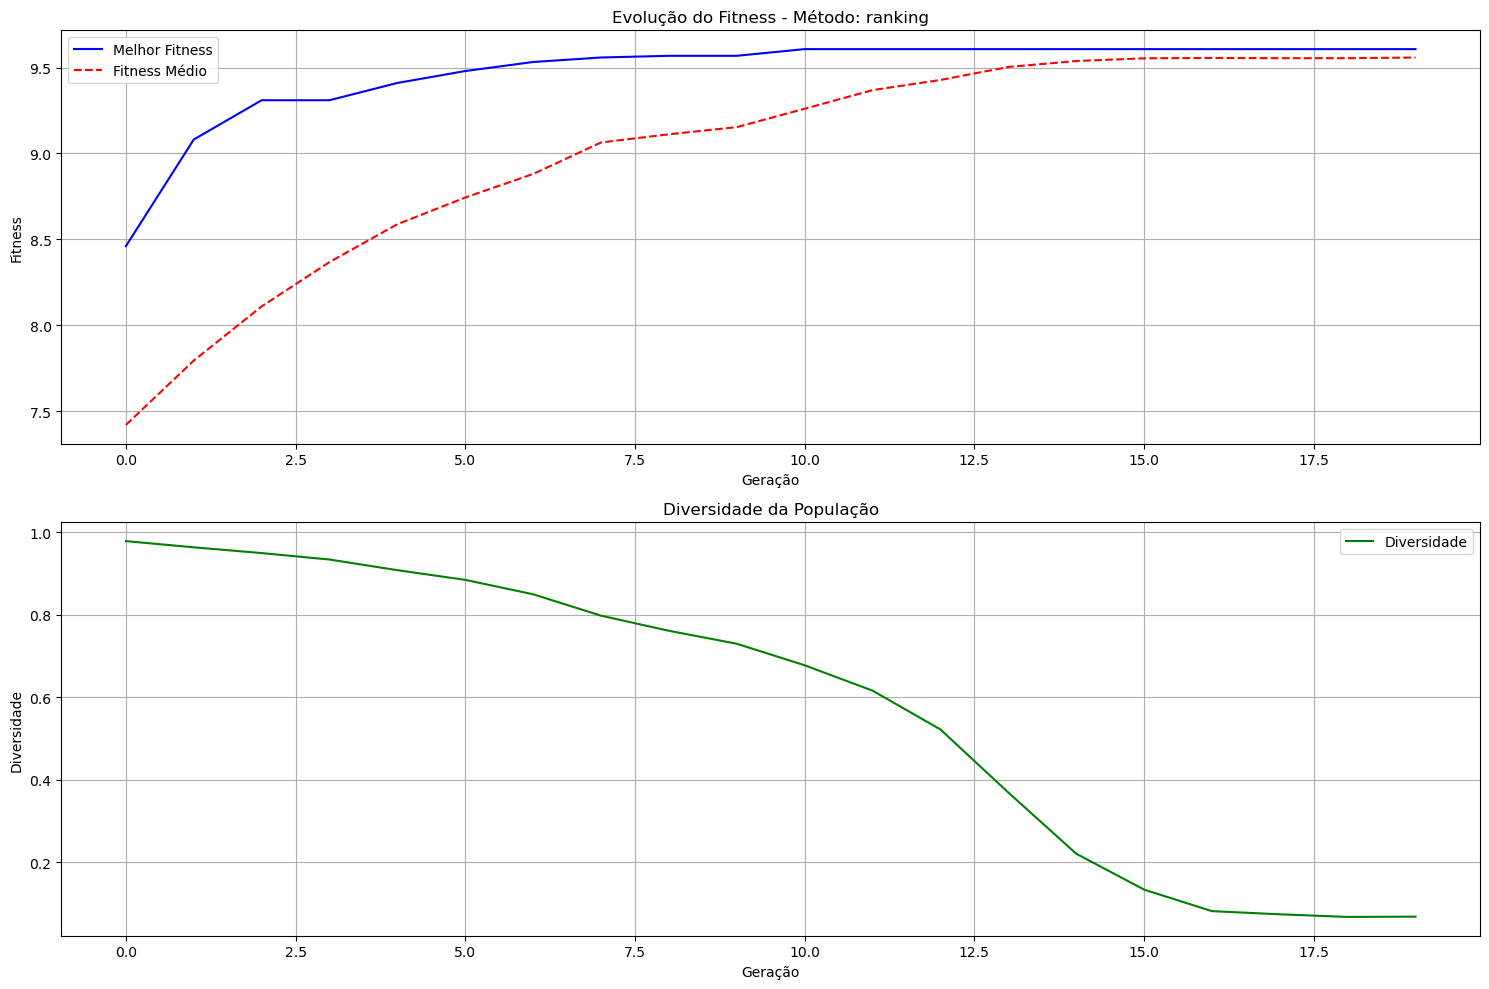


Melhor Lineup Encontrado:
--------------------------------------------------------------------------------
Nome: Aaron Gordon
Posição: Forward
Salário: $21,266,182.00
OBPM: 20.03
DBPM: 11.03
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Nikola Jokić
Posição: Center
Salário: $43,290,601.00
OBPM: 21.30
DBPM: 10.37
TS%: 0.007
--------------------------------------------------------------------------------
Nome: Kevin Huerter
Posição: Guard-Forward
Salário: $15,669,643.00
OBPM: 18.30
DBPM: 14.70
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Trae Young
Posição: Guard
Salário: $40,064,220.00
OBPM: 16.57
DBPM: 16.20
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Tyrese Haliburton
Posição: Guard
Salário: $6,005,320.33
OBPM: 16.43
DBPM: 16.67
TS%: 0.006
--------------------------------------------------------------------------------
Salário 

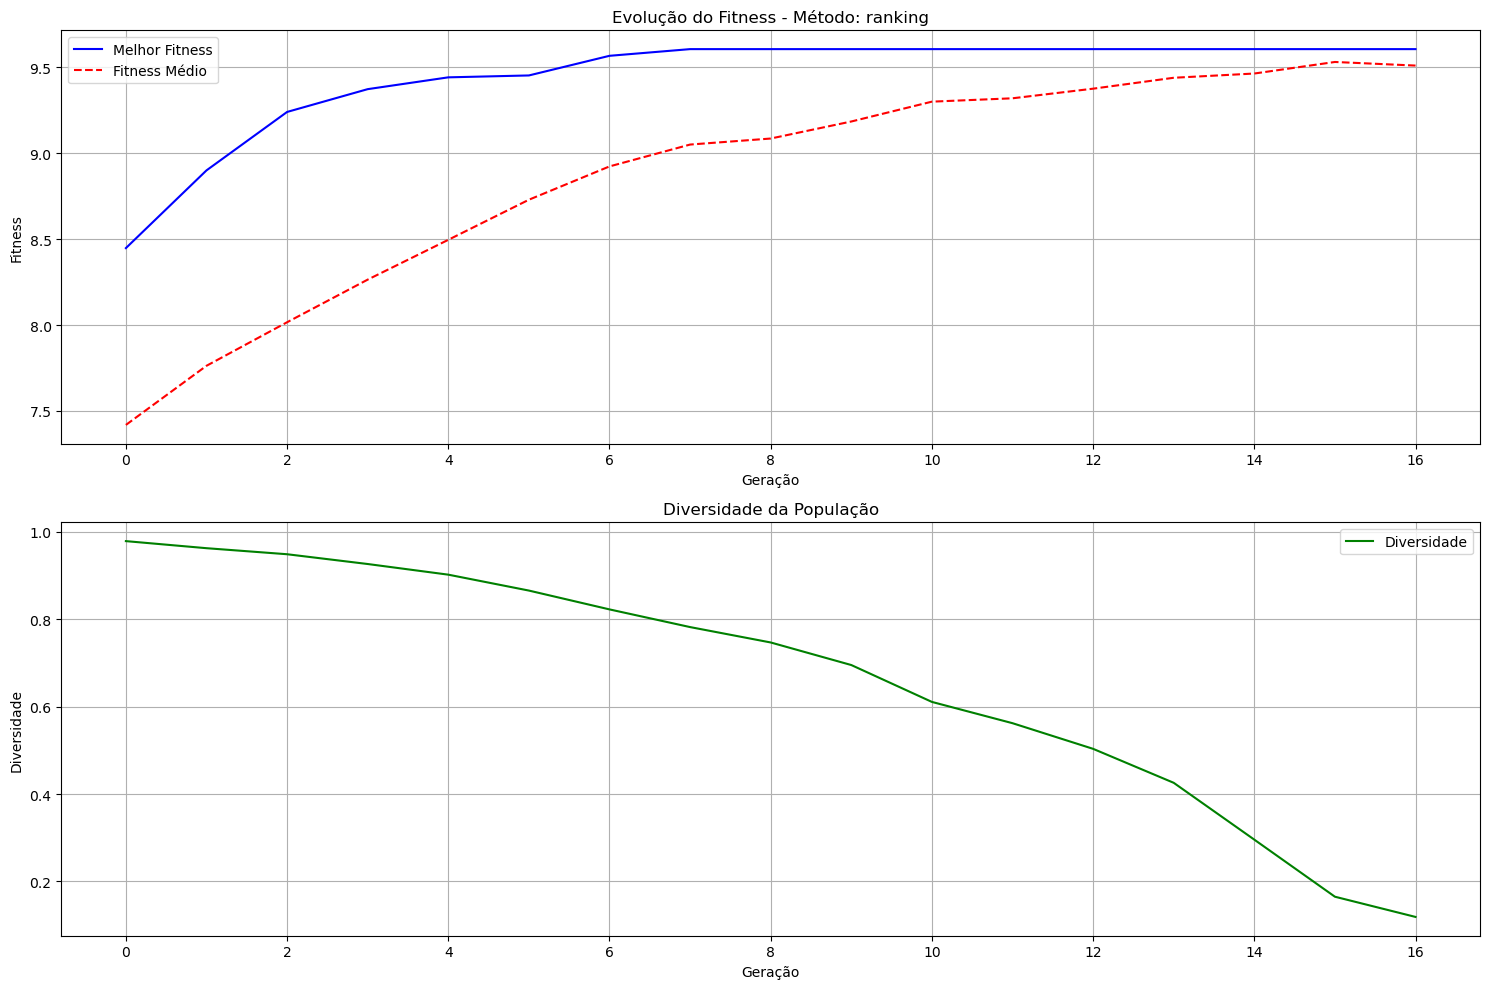


Melhor Lineup Encontrado:
--------------------------------------------------------------------------------
Nome: Aaron Gordon
Posição: Forward
Salário: $21,266,182.00
OBPM: 20.03
DBPM: 11.03
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Nikola Jokić
Posição: Center
Salário: $43,290,601.00
OBPM: 21.30
DBPM: 10.37
TS%: 0.007
--------------------------------------------------------------------------------
Nome: Kevin Huerter
Posição: Guard-Forward
Salário: $15,669,643.00
OBPM: 18.30
DBPM: 14.70
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Trae Young
Posição: Guard
Salário: $40,064,220.00
OBPM: 16.57
DBPM: 16.20
TS%: 0.006
--------------------------------------------------------------------------------
Nome: Tyrese Haliburton
Posição: Guard
Salário: $6,005,320.33
OBPM: 16.43
DBPM: 16.67
TS%: 0.006
--------------------------------------------------------------------------------
Salário 

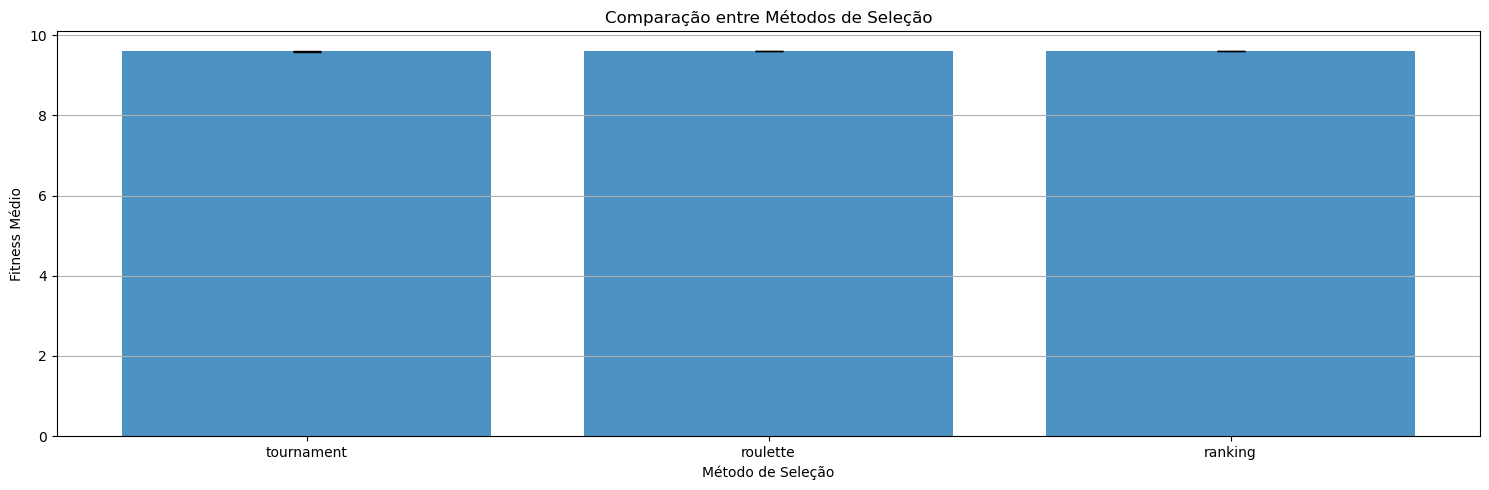

In [45]:
# Criar o otimizador com os novos parâmetros
optimizer = NBALineupOptimizer(
    players_df=df,
    population_size=1000,
    max_generations=50,
    convergence_generations=10,  # Parar se não houver melhoria em 10 gerações
    target_fitness=None,  # Opcional: definir uma meta de fitness
    min_diversity=0.01 # Parar se a diversidade ficar muito baixa
 
)

# Comparar diferentes métodos de seleção
results = optimizer.compare_selection_methods(num_runs=3)
